# Rock-Paper-Scissors
Training a CNN on rock-paper-scissors hand images to build a simple game application

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

## Load dataset

In [39]:
# define paths
train_folder = 'dataset/train'
test_folder = 'dataset/test'
validation_folder = 'dataset/validation'

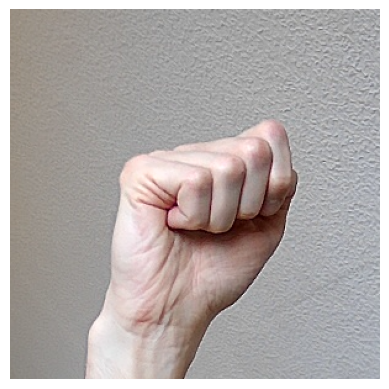

In [72]:
# open test picture
def load_image(img_path: str) -> np.ndarray:
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

def display_image(image: np.ndarray) -> None:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

rock_folder = 'dataset/train/rock'
test_image = random.choice(os.listdir(rock_folder))
image_path = os.path.join(rock_folder, test_image)
img = load_image(image_path)
display_image(img)

## Preparing data for the model

In [73]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

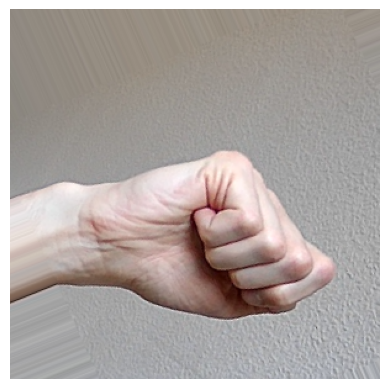

In [98]:
random_img = image_gen.random_transform(img)
display_image(random_img)

In [7]:
image_gen.flow_from_directory(train_folder)

Found 3784 images belonging to 3 classes.


In [8]:
image_gen.flow_from_directory(test_folder)

Found 1259 images belonging to 3 classes.


## Create Model

In [9]:
# Image shape Tensor
image_shape = (150, 150, 3)

# create sequential modle
model = Sequential()

model.add(InputLayer(input_shape=image_shape))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))

# Add 50% dropout to help reduce overfitting
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=3, activation='softmax'))  # 3 classes: 0=rock, 1=paper 2=scissors

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)     

## Moving the model to GPU

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11393921122922641021
xla_global_id: -1
]


## Training Model

In [11]:
batch_size = 32

train_image_gen = image_gen.flow_from_directory(
    directory=train_folder,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3784 images belonging to 3 classes.


In [12]:
test_image_gen = image_gen.flow_from_directory(
    directory=test_folder,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1259 images belonging to 3 classes.


In [13]:
# indices
class_indices = train_image_gen.class_indices
class_labels = {v:k for k, v in class_indices.items()}
print(class_indices)
print(class_labels)

{'paper': 0, 'rock': 1, 'scissors': 2}
{0: 'paper', 1: 'rock', 2: 'scissors'}


In [14]:
results = model.fit(
    train_image_gen,
    epochs=100,
    steps_per_epoch=train_image_gen.samples/train_image_gen.batch_size,
    validation_data=test_image_gen,
    validation_steps=test_image_gen.samples/test_image_gen.batch_size,
    verbose=2)

Epoch 1/100




KeyboardInterrupt: 

## Model Evaluation

In [ ]:
plt.plot(results.history['accuracy'])

## Save model

In [18]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
model.save(f'models/rps_v03_100epochs_{timestamp}.h5')

## Image prediction Test

In [49]:
model = load_model('models/rps_v03_100epochs_20240208_1512.h5')
class_indices = {'paper': 0, 'rock': 1, 'scissors': 2}
class_labels = {v:k for k, v in class_indices.items()}

img_file = r'test\paper.png'
img = image.load_img(img_file, target_size=(150, 100))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255

prediction_prob = model.predict(img, verbose=0)
print(prediction_prob)
predicted_class_index = np.argmax(prediction_prob)
print(predicted_class_index)
predicted_class_prob = prediction_prob[0][predicted_class_index]
print(predicted_class_prob)
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)

[[9.9999952e-01 5.0114755e-07 2.4848605e-08]]
0
0.9999995
paper


## New images prediction

In [ ]:
success = 0
failure = 0
total = 0

# load model

model = load_model('models/rps_v03_100epochs_20240208_1512.h5')

for subfolder in ['rock', 'paper', 'scissors']:

    current_folder = os.path.join(validation_folder, subfolder)

    for img_name in os.listdir(current_folder):

        img_file = os.path.join(current_folder, img_name)

        img = image.load_img(img_file, target_size=(150, 100))
        img = image.img_to_array(img)

        # add batch dimension
        img = np.expand_dims(img, axis=0)
        img = img/255

        # image prediction probability
        prediction_prob = model.predict(img, verbose=0)
        # print(prediction_prob)

        # Get predicted class index
        predicted_class_index = np.argmax(prediction_prob)

        # Map predicted class index to class label
        predicted_class_label = class_labels[predicted_class_index]

        # Print predicted class label
        if subfolder == predicted_class_label:
            success += 1
            result = 'success'
        else:
            failure += 1
            result = 'failure'

        print(f'Image: {img_name} | Class/Predicted: {subfolder} >> {predicted_class_label} | {result}')
        total += 1

print(f"{100*'-'}\nTotal: {total} | Success: {success} | Failure: {failure} | Accuracy: {success/total*100:.2f}%")



## Test on camera

In [51]:
model = load_model('models/rps_v03_100epochs_20240208_1512.h5')
class_labels = {0: 'paper', 1: 'rock', 2: 'scissors'}

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cv2.namedWindow('Rock Paper Scissors')

x, y, w, h = 895, 78, 200, 300

while True:

    try:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        roi = frame[y:y+h, x:x+w]

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

        # copy and resize roi
        roi_copy = cv2.resize(roi, (100, 150))
        img = image.img_to_array(roi_copy)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0
        prediction_prob = model.predict(img, verbose=0)
        predicted_class_index = np.argmax(prediction_prob)
        predicted_class_label = class_labels[predicted_class_index]
        predicted_class_prob = prediction_prob[0][predicted_class_index]

        frame[0:150, 0:100] = roi_copy

        # Display prediction
        if predicted_class_prob < 0.9:
            label = 'None'
        else:
            label = f'{predicted_class_label} ({predicted_class_prob:.2f})'

        position = x, y + h + 20
        cv2.putText(frame, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

        # Display frame
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0,0,255), 2)
        cv2.imshow('Rock Paper Scissors', frame)

    except Exception as e:
        print(e)
        break

cap.release()
cv2.destroyAllWindows()